In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


import torch
from sklearn.decomposition i   mport PCA
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm
import math
import os

from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')        

Mounted at /content/drive


**Data Loading**

In [3]:
# train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
# target = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
# test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
# # train_drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
# train_drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')

# print(os.path.dirname(os.path.abspath('Bioinf590_TabNet.ipynb')))

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Bioinf 590/Final Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('In Working Directory', os.listdir(GOOGLE_DRIVE_PATH))

DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'lish-moa')

train = pd.read_csv(DATA_PATH+"/train_features.csv")
train_processed = pd.read_csv(DATA_PATH+"/train_processed_final.csv")

train_targets = pd.read_csv(DATA_PATH+'/train_targets_scored.csv')
# train_targets.drop(columns=["sig_id"], inplace=True)
print(DATA_PATH)
# test = pd.read_csv(DATA_PATH+'/test_features.csv')
train_drug = pd.read_csv(DATA_PATH+'/train_drug.csv')

print('********* Read all the data into Pandas ************')

In Working Directory ['lish-moa', 'TabNet.pt', 'y_test_pred.pt', 'TabNet_zScore.pt', 'TabNet_no_zScore.pt', 'Early_Findings.gdoc', 'baseline_sklearn.ipynb', 'baseline-NN.ipynb', 'Bioinf590_TabNet.ipynb', 'Bioinf_Final_Presentation.gslides', 'baseline+1D CNN.ipynb']
drive/My Drive/Bioinf 590/Final Project/lish-moa
********* Read all the data into Pandas ************


**DATA PREPROCESSING**

In [4]:
all_columns = set(train.columns)
print(len(all_columns))
remove_columns = set(['sig_id', 'cp_type', 'cp_time', 'cp_dose'])
train_columns = all_columns - remove_columns
print(len(train_columns))
target_columns = set(train_targets.columns) - set(['sig_id'])
print(len(target_columns))


876
872
206


In [5]:
def z_Score_norm(train):
  GENES = [col for col in train.columns if col.startswith('g-')]
  CELLS = [col for col in train.columns if col.startswith('c-')]
  control_data = train[train['cp_type'] == 0]
  control_24 = control_data[control_data['cp_time'] == 0] ##Control data for cp_time = 24
  control_48 = control_data[control_data['cp_time'] == 1]
  control_72 = control_data[control_data['cp_time'] == 2]

  for col in (GENES+CELLS):
    train.loc[train['cp_time'] == 0, col] -= control_24[col].mean()
    train.loc[train['cp_time'] == 0, col] /= control_24[col].std()

    train.loc[train['cp_time'] == 1, col] -= control_48[col].mean()
    train.loc[train['cp_time'] == 1, col] /= control_48[col].std()

    train.loc[train['cp_time'] == 2, col] -= control_72[col].mean()
    train.loc[train['cp_time'] == 2, col] /= control_72[col].std()

  return train

In [6]:
# THIS CODE IS OLD AND NOT NEEDED

# z_Score_normalize = True

# if z_Score_normalize == True:
#     train = z_Score_norm(train)
# train_tensor = torch.tensor(train[train_columns].to_numpy()).double()
# target_tensor = torch.tensor(target[target_columns].to_numpy()).double() #,dtype=torch.double
# test_tensor = torch.tensor(test[train_columns].to_numpy()).double()


**DATA SEQUENCE PROCESSING**

In [7]:
'Creates a list that contains the 6 unique pertubations for each drug'
'Input: train -> Unprocessed train data.    train_targets -> labels for train data'

'Output: drugs_gathered -> a list of length N containing (6,896) arrays'
'drug_labels -> GT labels for each pertubation..'

def gather_6_row_drugs(train,train_drug,train_targets):

  M = train['sig_id'].shape[0]
  drug_id_list = [] ### The drug_ids that have been gathered... size N
  drugs_gathered = [] ### Contains drug_ids respective 6 samples... length of 2774 of arrays (6,876)
  drugs_labels = [] ## May not need this.. Labels for each of the 6 samples. length 2774 of arrays (6,206)
  for i in range(M):

    drug_id = train_drug['drug_id'][i]
    if (drug_id not in drug_id_list):
      drug_id_list.append(drug_id)
    else:
      continue

    sig_ids = train_drug[train_drug['drug_id'] == drug_id]['sig_id'].index

    curr_drug = train.loc[sig_ids] ## shape (6,877)
    if curr_drug.shape[0] is not 6:
      continue
    drugs_gathered.append(curr_drug)
    curr_drug_labels = train_targets.loc[sig_ids] 
    drugs_labels.append(curr_drug_labels) ##may not need this...

  return drugs_gathered, drugs_labels

def sort_by_dose_time(drugs_gathered):

  sorted = []
  for drug in drugs_gathered:
    drug = drug.sort_values(by=['cp_dose','cp_time'])
    sorted.append(drug)
  return sorted

In [8]:
train.shape, train_drug.shape,train_targets.shape

((23814, 876), (23814, 2), (23814, 207))

In [9]:
drugs_gathered, drugs_labels = gather_6_row_drugs(train,train_drug,train_targets)
drugs_gathered = sort_by_dose_time(drugs_gathered) ##shape (2774,6,876)

**CONVERT TO PYTORCH TENSOR FOR SEQUENCED TRAIN DATA**

In [10]:
# drugs_gathered[0]
'''
Concatenates all training data into pytorch tensor
removes sig_id, cp_type,cp_time,dosage -- since the data is already ordered by it

'''

t1 = torch.tensor(drugs_gathered[0][train_columns].to_numpy())
t2 = torch.tensor(drugs_gathered[1][train_columns].to_numpy())

drug_tensor = torch.cat([t1.unsqueeze(0),t2.unsqueeze(0)],axis=0)
print(drug_tensor.shape)

for idx in range(2,len(drugs_gathered)):
  t_next = torch.tensor(drugs_gathered[idx][train_columns].to_numpy()).unsqueeze(0)
  drug_tensor = torch.cat([drug_tensor,t_next],axis=0)
  
print(drug_tensor.shape)

torch.Size([2, 6, 872])
torch.Size([2774, 6, 872])


**CONVERT TO SEQUENCE DATA FOR TARGET LABELS**

Also only takes into account first row from (6,206) -> (206,) since all the rows are same for same drug id -- one MoA

In [11]:
t1 = torch.tensor(drugs_labels[0][target_columns].iloc[0].to_numpy())
t2 = torch.tensor(drugs_labels[1][target_columns].iloc[0].to_numpy())

drug_target_tensor = torch.cat([t1.unsqueeze(0),t2.unsqueeze(0)],axis=0)
print(drug_target_tensor.shape)

for idx in range(2,len(drugs_labels)):
  t_next = torch.tensor(drugs_labels[idx][target_columns].iloc[0].to_numpy()).unsqueeze(0)
  
  drug_target_tensor = torch.cat([drug_target_tensor,t_next],axis=0)
  
print(drug_target_tensor.shape)

torch.Size([2, 206])
torch.Size([2774, 206])


In [ ]:
# check if any other MoA where activated for one drug
# for idx in range(0, len(drugs_labels)):
#   for i in drugs_labels[idx].sum().drop('sig_id'):
#     if(i>0 and i!=6):
#       print(i)
# only one MoA activated for one drug

**set up correct device and dtype and validation sets**

In [12]:

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')

train_tensor = drug_tensor.to(DEVICE)
target_tensor = drug_target_tensor.to(DEVICE)
print(f"train tensor shape {train_tensor.shape} and size {train_tensor.device}")
print(f"target tensor shape {target_tensor.shape} and size {target_tensor.device}")
DTYPE = train_tensor.dtype
print(f"Device:{DEVICE} and dtype:{train_tensor.dtype}")

train tensor shape torch.Size([2774, 6, 872]) and size cpu
target tensor shape torch.Size([2774, 206]) and size cpu
Device:cpu and dtype:torch.float64


In [13]:
def train_model(train_data,val_data,model,learning_rate,weight_decay, num_epochs):
    loss_fn   = nn.BCEWithLogitsLoss() # nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_data))
    epoch_loss_list = []
    val_loss_list = []

    # enumerate epochs
    for epoch in range(num_epochs):
        # enumerate mini batches
        epoch_loss = 0
        start_time = time.time()
        model.train()
        for i, (x, y) in enumerate(train_data):
            optimizer.zero_grad()            
            y_pred = model(x)
            y = y.double() 
            # print(y.shape, y_pred.shape)
            loss = loss_fn(y,y_pred)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss
        epoch_loss /= i
        epoch_time = (time.time() - start_time)/60
        epoch_loss_list.append(epoch_loss)
        # print(f"EPOCH: {epoch}, train_loss: {epoch_loss}, in time {epoch_time}")
    
        # validation set
        # check validation accuracy
        model.eval()
        final_val_loss = 0
        with torch.no_grad():
          for i,(x,y) in enumerate(val_data):
              y_pred = model(x)
              loss = loss_fn(y,y_pred)
              final_val_loss += loss
          final_val_loss /= i
          val_loss_list.append(final_val_loss)
          print(f"EPOCH: {epoch}, train_loss: {epoch_loss}, validation loss {final_val_loss} ")
          # print(f" validation loss {final_val_loss}")

    return model, epoch_loss_list,val_loss_list

def test_model(data, model):      
    model.eval()
    with torch.no_grad():
        outputs = model(data)
    return outputs


In [28]:
class Model_NN(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size,dtype,model_cnn):
        super(Model_NN, self).__init__()
        self.cnn = model_cnn
        self.batch_norm1 = nn.BatchNorm1d(num_features)  
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.4)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.batch_norm1(x)
        # x = self.dropout1(x)
        # x = F.relu(self.dense1(x))
        x = self.dropout1(F.relu(x))
        x = (self.dense1(x))
        
        x = self.batch_norm2(x)
        # x = self.dropout2(x)
        # x = F.relu(self.dense2(x))
        x = self.dropout2(F.relu(x))
        x = (self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

class Model_CNN(nn.Module):
    def __init__(self, in_channels,hidden_channels,num_classes):
        super(Model_CNN, self).__init__()
        '''
        Input : (Batch_Size,6,872)
        
        Output : (Batch_size,872) 
        using 1d convolution
        
        '''
        num_features = 872
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.cnn_1d_1 = nn.Conv2d(in_channels,hidden_channels,kernel_size=1,stride=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.cnn_1d_2 = nn.Conv2d(hidden_channels,1,kernel_size=1,stride=1)
        self.fc = nn.utils.weight_norm((nn.Linear(num_features, num_classes)))

    def forward(self,x):
      print(x.shape)
      batch_size = x.shape[0]
      xx = x.unsqueeze(2)
      xx = self.cnn_1d_1(xx)
      xx = self.relu(xx)
      xx = self.dropout(xx)
      xx = self.cnn_1d_2(xx)
      xx = self.relu(xx)
      xx = xx.reshape(batch_size,-1)
      xx = self.fc(xx) # output is (206,) or 872 depending on the next model
      return xx

In [ ]:
batch_size  = 32

train_tensor = train_tensor.to(torch.float64)
target_tensor = target_tensor.to(torch.float64)

dataset = TensorDataset(train_tensor,target_tensor)
train_set, val_set = torch.utils.data.random_split(dataset, [2200,train_tensor.shape[0]-2200])
# print(train_set.shape,val_set.shape)
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# hyperparameters
hidden_size = 1024
learning_rate = (1e-6)
weight_decay = 1e-5
num_epochs = 20

num_classes_cnn =  len(train_columns) #206
model_cnn = Model_CNN(in_channels=6,hidden_channels=3,num_classes=num_classes_cnn) #206 when it was nothing
model_cnn.to(DEVICE).to(target_tensor)

model = Model_NN(len(train_columns),len(target_columns),hidden_size,DTYPE,model_cnn)
model.to(DEVICE).to(target_tensor)

print(train_tensor.dtype,target_tensor.dtype)
model_trained, epoch_loss_list,val_loss_list = train_model(train_data,val_data,model,learning_rate,weight_decay, num_epochs)

# predictions = test_model(test_tensor,model)

In [37]:
model

Model_NN(
  (cnn): Model_CNN(
    (cnn_1d_1): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (cnn_1d_2): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (fc): Linear(in_features=872, out_features=872, bias=True)
  )
  (batch_norm1): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=872, out_features=1024, bias=True)
  (batch_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (dense2): Linear(in_features=1024, out_features=1024, bias=True)
  (batch_norm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=1024, out_features=206, bias=True)
)

Text(0, 0.5, 'Loss')

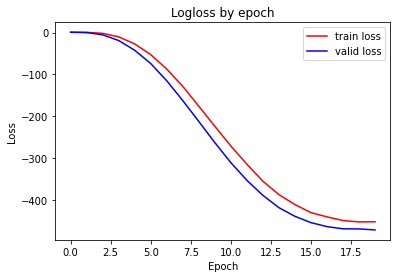

In [ ]:
plt.plot(np.arange(len(epoch_loss_list)), epoch_loss_list, color='red',label='train loss')
plt.plot(np.arange(len(val_loss_list)), val_loss_list, color='blue', label='valid loss')
plt.title('Logloss by epoch')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
batch_size_list = [32] #[16,32,64,128]
lr_list = [1e-6]       #[1e-6,1e-5,1e-4,1e-3,1e-2]
best_val_loss = math.inf
best_lr = None
best_bs = None

for batch_size in batch_size_list:
  for learning_rate in lr_list:
    print('________________',batch_size,learning_rate,'___________________')
    dataset = TensorDataset(train_tensor.double(),target_tensor)
    train_set, val_set = torch.utils.data.random_split(dataset, [2200,train_tensor.shape[0]-2200])
    # print(train_set.shape,val_set.shape)
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_data = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    learning_rate = (learning_rate)
    weight_decay = 1e-5
    num_epochs = 20
    num_classes_cnn = 206 # len(train_columns)
    model_cnn = Model_CNN(in_channels=6,hidden_channels=3,num_classes=num_classes_cnn) #206 when it was nothing
    model_cnn.to(DEVICE).to(DTYPE)
    model_trained, epoch_loss_list,val_loss_list = train_model(train_data,val_data,model_cnn,learning_rate,weight_decay, num_epochs)
    val_loss = val_loss_list[-1]
    if (val_loss<best_val_loss):
      best_val_loss = val_loss
      best_lr = learning_rate
      best_bs = batch_size

print(best_val_loss,best_lr,best_bs)    



Text(0, 0.5, 'Loss')

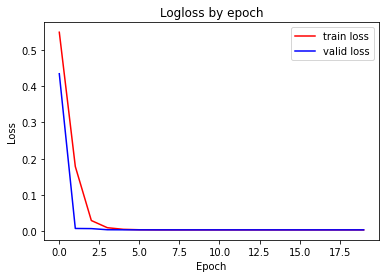

In [ ]:
plt.plot(np.arange(len(epoch_loss_list)), epoch_loss_list, color='red',label='train loss')
plt.plot(np.arange(len(val_loss_list)), val_loss_list, color='blue', label='valid loss')
plt.title('Logloss by epoch')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

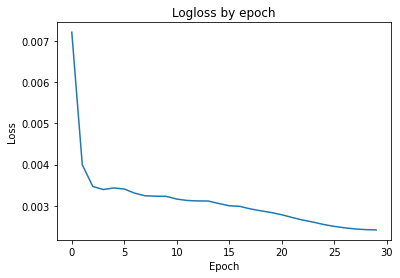

In [ ]:
plt.plot(np.arange(len(epoch_loss_list)), epoch_loss_list)
plt.title('Logloss by epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# from sklearn.metrics import log_loss

# xx,yy = train_set[:]
# y_pred = test_model(xx,model)
# ll = log_loss(yy,y_pred)
# print(ll)

In [ ]:
# from sklearn.metrics import average_precision_score
# from sklearn.preprocessing import label_binarize
'INPUT: validation labels (500, 206)'
'INPUT: validation predictions (500,206)'



def precision_recall(valid_targets, predictions):


  return precision, recall

In [ ]:
def auc_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        try:
            results[i] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except:
            pass
    return results.mean()